# Zadanie 3

Zadanie zostało zrobione na podstawie kursu z datacamp : https://campus.datacamp.com/courses/intermediate-deep-learning-with-pytorch/images-convolutional-neural-networks?ex=5 
Oraz artykułu cs231 : https://cs231n.github.io/convolutional-networks/?utm_source=chatgpt.com

Używam Clouds dataset ( 7 klas ) - z kaggla

https://www.kaggle.com/datasets/jockeroika/clouds-photos/data

Libraries

In [100]:
import os, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch_directml
from torchmetrics.classification import Accuracy


from torchvision.datasets import CIFAR10

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(123)

device = torch_directml.device()
print("device:", device)




device: privateuseone:0


Downloading data

In [42]:
dml = torch_directml.device()

device = torch_directml.device()


Transformers for input images

In [103]:

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)

train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])


dataset_train = CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
dataset_test  = CIFAR10(root="./data", train=False, download=True, transform=test_transforms)

num_classes = 10



Files already downloaded and verified


c:\Users\egrac\Desktop\Cloud-Image-Classification-PyTorch-\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Files already downloaded and verified


Preparing dataloader

In [117]:
root = "./data"

dataset_train = CIFAR10(
    root=root,
    train=True,
    download=True,
    transform=train_transforms
)

dataset_test = CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=test_transforms   
)

num_classes = 10

dataloader_train = DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2
)

Files already downloaded and verified


c:\Users\egrac\Desktop\Cloud-Image-Classification-PyTorch-\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Files already downloaded and verified


Convolutional Neural Networks

Architektura sieci - artykuł cs231

![image](images/architecture.png)



Budowa sieci podstawowej:
    (Conv -> Elu)x2 -> MaxPool ->(Conv -> Elu)x2 -> MaxPool -> Conv->Elu -> MaxPool -> AdaptiveAvg -> DenseLayer


In [46]:


class Net1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # teraz mamy 32 x 64 x 64

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # teraz mamy 32 x 64 x 64

            nn.MaxPool2d(kernel_size=2),
            # teraz mamy 64 x 32 x 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # teraz mamy 64 x 64 x 64
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # teraz mamy 64 x 64 x 64
            
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # teraz mamy 128 x 32 x 32

            nn.AdaptiveAvgPool2d((1,1)),
            # adaptive avg pool przeciwdziała przeuczeniu się modelu

            nn.Flatten(),
            # teraz mamy 128 

            
        )
    
        # dense layer at the end
        self.classifier = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.features_extractor(x)
        x = self.classifier(x)
        return x
    


In [69]:
class Net2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features_extractor(x)
        return self.classifier(x)


Batchnormalization pomaga sieci w uczeniu się (stabilizuje proces uczenia się naszej sieci)

In [63]:
class Net3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),

            nn.Dropout(p=0.25),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        return self.classifier(self.features_extractor(x))


Dropout zapobiega przeuczaniu się sieci konwolucyjnej, lecz przy naszej sieci i małym zbiorze uczącym ma ona znikomy wpływ, lub czasem negatywny

In [78]:

net1 = Net1(num_classes=10)
net2 = Net2(num_classes=10)
net3 = Net3(num_classes=10)

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

@torch.no_grad()
def score(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct, total

def fit(model, train_loader, test_loader, device, epochs=10, lr=1e-3):
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)

    hist = []
    for e in range(1, epochs + 1):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device, dtype=torch.long)

            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()

        scheduler.step()
        c, t = score(model, test_loader, device)
        acc = c / t
        print(f"epoch {e:02d}: score {c}/{t}  acc={acc:.4f}")
        hist.append({"epoch": e, "acc": acc})

    return model, hist


epoch 01: score 3742/10000  acc=0.3742
epoch 02: score 4187/10000  acc=0.4187
epoch 03: score 4825/10000  acc=0.4825
epoch 04: score 5206/10000  acc=0.5206
epoch 05: score 5271/10000  acc=0.5271
epoch 06: score 5615/10000  acc=0.5615
epoch 07: score 5515/10000  acc=0.5515
epoch 08: score 5790/10000  acc=0.5790
epoch 09: score 6283/10000  acc=0.6283
epoch 10: score 6208/10000  acc=0.6208
epoch 11: score 6317/10000  acc=0.6317
epoch 12: score 5869/10000  acc=0.5869
epoch 13: score 6417/10000  acc=0.6417
epoch 14: score 6501/10000  acc=0.6501
epoch 15: score 6526/10000  acc=0.6526
epoch 16: score 6571/10000  acc=0.6571
epoch 17: score 6477/10000  acc=0.6477
epoch 18: score 6823/10000  acc=0.6823
epoch 19: score 6559/10000  acc=0.6559
epoch 20: score 6976/10000  acc=0.6976
epoch 21: score 6968/10000  acc=0.6968
epoch 22: score 6811/10000  acc=0.6811
epoch 23: score 7047/10000  acc=0.7047
epoch 24: score 7062/10000  acc=0.7062
epoch 25: score 7153/10000  acc=0.7153
epoch 26: score 7163/1000

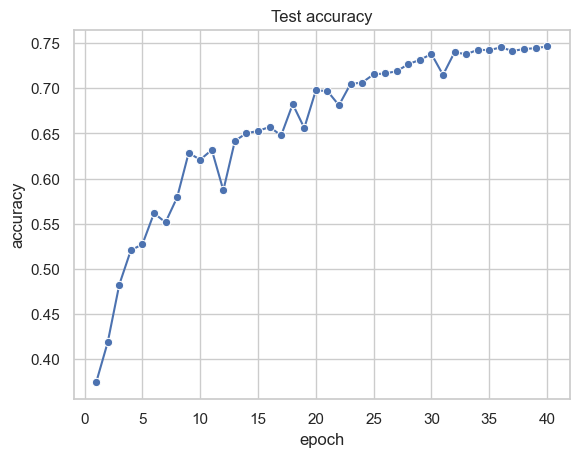

In [119]:

num_classes = 10
model = Net2(num_classes=num_classes)  
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=40, lr=0.001)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure()
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy")
plt.ylabel("accuracy")
plt.show()

Decided to upgrade network with normalization, added one conv layer and dropout

In [120]:
class Net2Plus(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),                    
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        return self.classifier(self.features(x))


epoch 01: score 3868/10000  acc=0.3868
epoch 02: score 4789/10000  acc=0.4789
epoch 03: score 5243/10000  acc=0.5243
epoch 04: score 5536/10000  acc=0.5536
epoch 05: score 5774/10000  acc=0.5774
epoch 06: score 6247/10000  acc=0.6247
epoch 07: score 5859/10000  acc=0.5859
epoch 08: score 6369/10000  acc=0.6369
epoch 09: score 6613/10000  acc=0.6613
epoch 10: score 6694/10000  acc=0.6694
epoch 11: score 6411/10000  acc=0.6411
epoch 12: score 6762/10000  acc=0.6762
epoch 13: score 6954/10000  acc=0.6954
epoch 14: score 6658/10000  acc=0.6658
epoch 15: score 7247/10000  acc=0.7247
epoch 16: score 7087/10000  acc=0.7087
epoch 17: score 7303/10000  acc=0.7303
epoch 18: score 7316/10000  acc=0.7316
epoch 19: score 7114/10000  acc=0.7114
epoch 20: score 7568/10000  acc=0.7568
epoch 21: score 7488/10000  acc=0.7488
epoch 22: score 6712/10000  acc=0.6712
epoch 23: score 7379/10000  acc=0.7379
epoch 24: score 7664/10000  acc=0.7664
epoch 25: score 7833/10000  acc=0.7833
epoch 26: score 7769/1000

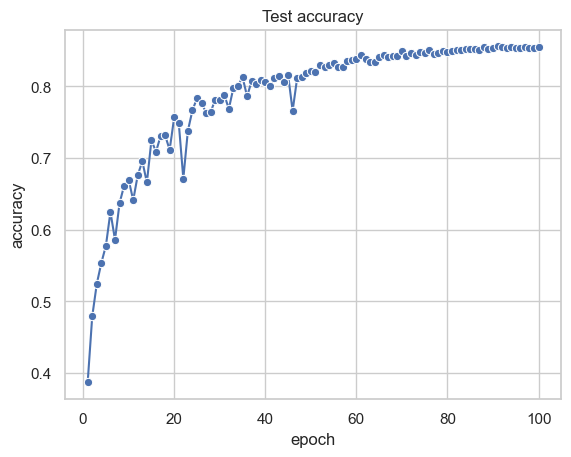

In [123]:
num_classes = 10
model = Net2Plus(num_classes=num_classes)  
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=100, lr=0.001)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure()
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy")
plt.ylabel("accuracy")
plt.show()

Managed to ocassionally gain 84% acc, but final bareer seems to be around 80%

In [115]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) 
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

epoch 01: score 6528/10000  acc=0.6528
epoch 02: score 7228/10000  acc=0.7228
epoch 03: score 7538/10000  acc=0.7538
epoch 04: score 6777/10000  acc=0.6777
epoch 05: score 7517/10000  acc=0.7517
epoch 06: score 7462/10000  acc=0.7462
epoch 07: score 7998/10000  acc=0.7998
epoch 08: score 8163/10000  acc=0.8163
epoch 09: score 7879/10000  acc=0.7879
epoch 10: score 8003/10000  acc=0.8003
epoch 11: score 7719/10000  acc=0.7719
epoch 12: score 8211/10000  acc=0.8211
epoch 13: score 7893/10000  acc=0.7893
epoch 14: score 8149/10000  acc=0.8149
epoch 15: score 8211/10000  acc=0.8211
epoch 16: score 8281/10000  acc=0.8281
epoch 17: score 8321/10000  acc=0.8321
epoch 18: score 7877/10000  acc=0.7877
epoch 19: score 8151/10000  acc=0.8151
epoch 20: score 8446/10000  acc=0.8446
epoch 21: score 8207/10000  acc=0.8207
epoch 22: score 8316/10000  acc=0.8316
epoch 23: score 8418/10000  acc=0.8418
epoch 24: score 8494/10000  acc=0.8494
epoch 25: score 8503/10000  acc=0.8503
epoch 26: score 8333/1000

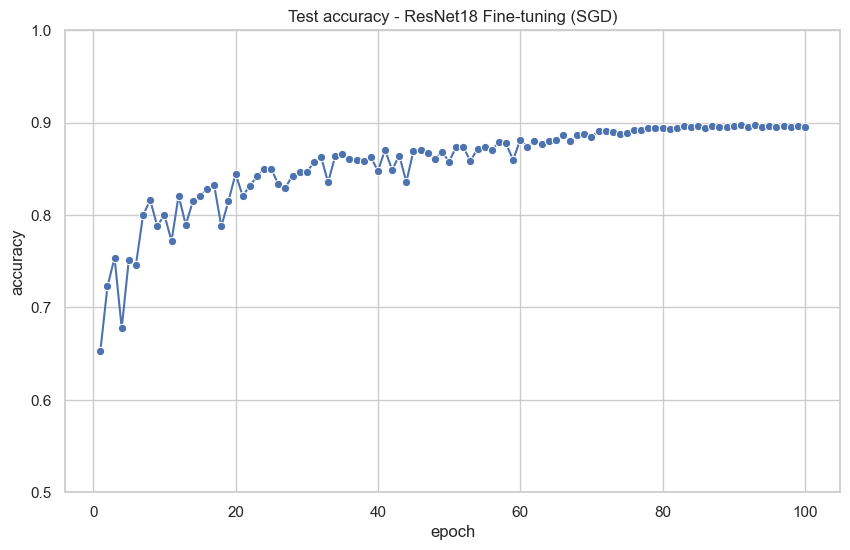

In [122]:
model, hist = fit(model, dataloader_train, dataloader_test, device, epochs=100, lr=0.01)


df = pd.DataFrame(hist)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epoch", y="acc", marker="o")
plt.title("Test accuracy - ResNet18 Fine-tuning (SGD)")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.grid(True)
plt.ylim([0.5, 1.0])
plt.show()